Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset preview:
            Start Date        End Date Charging Time (hh:mm:ss)  Energy (kWh)  \
0  2020-01-01 09:11:00  1/1/2020 11:20                  2:08:25        12.885   
1  2020-01-01 09:32:00  1/1/2020 11:19                  1:47:06         5.936   
2  2020-01-01 09:44:00  1/1/2020 10:57                  1:12:40         3.652   
3  2020-01-01 09:45:00  1/1/2020 10:45                  1:00:15         6.031   
4  2020-01-01 09:45:00  1/1/2020 15:08                  5:22:07        32.260   

  Port Type  Port Number Plug Type  
0   Level 2            2     J1772  
1   Level 2            2     J1772  
2   Level 2            2     J1772  
3   Level 2            1     J1772  
4   Level 2            1     J1772  

Linear Regression Performance:
Training Set:
  R² Score: 0.852
  MAE: 2.532 kWh
  RMSE: 3.503 kWh
Validation Set:
  R² Score: 0.855
  MAE: 2.535

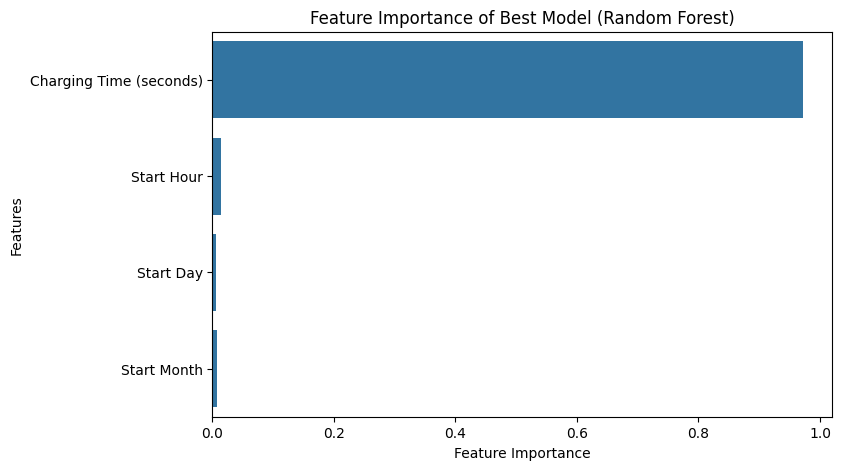

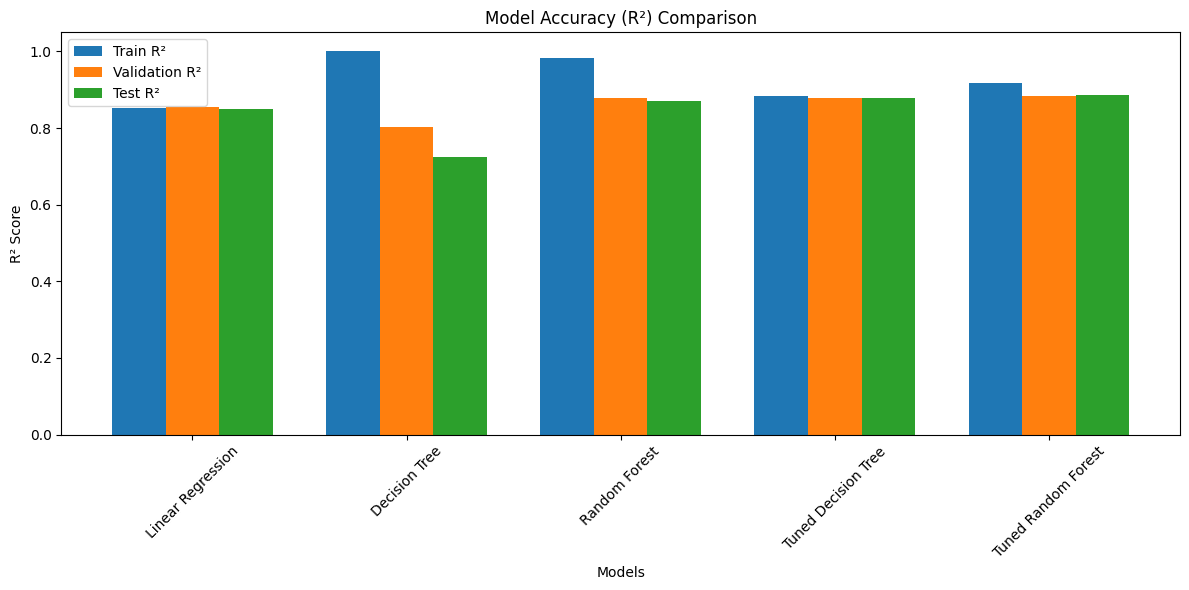

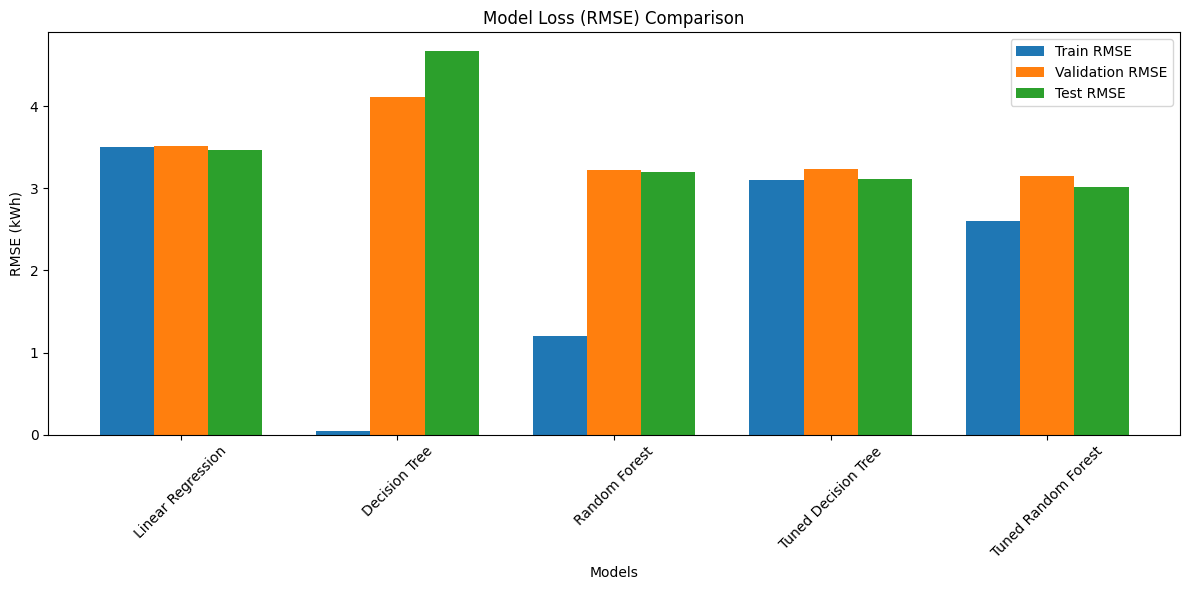

In [ ]:
# Hyperparameter Tuning Decision Tree, Random Forest Test 70 15 15   25 mins
# ------------------------------------------------------------
# 1. Import Libraries and Mount Google Drive
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path inside Google Drive
file_path = "/content/drive/My Drive/Colab Notebooks/2020_Data_V0.1.csv"

# Load the dataset
df = pd.read_csv(file_path)
print("Dataset preview:")
print(df.head())

# Convert 'Charging Time (hh:mm:ss)' to total seconds
def convert_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df['Charging Time (seconds)'] = df['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)

# Feature Engineering - Extract useful time-related features
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Start Hour'] = df['Start Date'].dt.hour   # Extract hour of the day
df['Start Day'] = df['Start Date'].dt.day       # Extract day of the month
df['Start Month'] = df['Start Date'].dt.month   # Extract month

# Feature Engineering - Create Charging Duration Categories
df['Charging Duration Category'] = pd.cut(df['Charging Time (seconds)'],
                                          bins=[0, 1800, 3600, 7200, 14400, np.inf],
                                          labels=['<30min', '30min-1hr', '1-2hr', '2-4hr', '>4hr'])

# Encode categorical features (Port Type and Charging Duration Category)
df = pd.get_dummies(df, columns=['Port Type', 'Charging Duration Category'], drop_first=True)

# Selecting relevant numerical features
features = ['Charging Time (seconds)', 'Start Hour', 'Start Day', 'Start Month']
X = df[features]
y = df['Energy (kWh)']

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# Split the dataset into 70% Train, 15% Test, 15% Validation
# First, split off 30% for testing + validation.
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
# Then split the temporary set equally into test and validation (each becomes 15% of the total data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# ------------------------------------------------------------

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

# Create a dictionary to store performance metrics for training, validation, and test sets.
results = {}

# Train and evaluate each model on training, validation, and test sets
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions for each set
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)

    # Compute metrics for the training set
    r2_train  = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Compute metrics for the validation set
    r2_val  = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Compute metrics for the test set
    r2_test  = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Save the results
    results[name] = {
         "train": {"R2": r2_train, "MAE": mae_train, "RMSE": rmse_train},
         "validation": {"R2": r2_val, "MAE": mae_val, "RMSE": rmse_val},
         "test": {"R2": r2_test, "MAE": mae_test, "RMSE": rmse_test}
    }

    # Print the results
    print(f"\n{name} Performance:")
    print("Training Set:")
    print(f"  R² Score: {r2_train:.3f}")
    print(f"  MAE: {mae_train:.3f} kWh")
    print(f"  RMSE: {rmse_train:.3f} kWh")
    print("Validation Set:")
    print(f"  R² Score: {r2_val:.3f}")
    print(f"  MAE: {mae_val:.3f} kWh")
    print(f"  RMSE: {rmse_val:.3f} kWh")
    print("Test Set:")
    print(f"  R² Score: {r2_test:.3f}")
    print(f"  MAE: {mae_test:.3f} kWh")
    print(f"  RMSE: {rmse_test:.3f} kWh")

# ------------------------------------------------------------
# Hyperparameter tuning using GridSearchCV (for Decision Tree and Random Forest)
param_grid_dt = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

print("\nPerforming Hyperparameter Tuning...")

# Decision Tree Hyperparameter Tuning
grid_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5, scoring='r2')
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

# Random Forest Hyperparameter Tuning
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("\nBest Decision Tree Hyperparameters:", grid_dt.best_params_)
print("Best Random Forest Hyperparameters:", grid_rf.best_params_)

# Train and evaluate the best (tuned) models and update the results
models["Tuned Decision Tree"] = best_dt
models["Tuned Random Forest"] = best_rf

for name in ["Tuned Decision Tree", "Tuned Random Forest"]:
    model = models[name]
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)

    r2_train  = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    r2_val  = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    r2_test  = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results[name] = {
         "train": {"R2": r2_train, "MAE": mae_train, "RMSE": rmse_train},
         "validation": {"R2": r2_val, "MAE": mae_val, "RMSE": rmse_val},
         "test": {"R2": r2_test, "MAE": mae_test, "RMSE": rmse_test}
    }

    print(f"\n{name} Performance (After Tuning):")
    print("Training Set:")
    print(f"  R² Score: {r2_train:.3f}")
    print(f"  MAE: {mae_train:.3f} kWh")
    print(f"  RMSE: {rmse_train:.3f} kWh")
    print("Validation Set:")
    print(f"  R² Score: {r2_val:.3f}")
    print(f"  MAE: {mae_val:.3f} kWh")
    print(f"  RMSE: {rmse_val:.3f} kWh")
    print("Test Set:")
    print(f"  R² Score: {r2_test:.3f}")
    print(f"  MAE: {mae_test:.3f} kWh")
    print(f"  RMSE: {rmse_test:.3f} kWh")

# ------------------------------------------------------------
# Additional Analysis:
# In addition to these metrics, you might consider:
# - Plotting residuals to check for patterns (indicative of non-linearity)
# - Comparing training vs. validation performance to check for overfitting/underfitting
# - Feature importance analysis (shown below for the best Random Forest model)
# ------------------------------------------------------------

# Plot feature importance for the best model (Random Forest)
best_model = best_rf
feature_importance = best_model.feature_importances_
feature_names = df[features].columns

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance of Best Model (Random Forest)")
plt.show()

# ------------------------------------------------------------
# Plotting training, validation, and test performance
# We will create two bar charts: one for accuracy (R²) and one for loss (RMSE).

# Prepare data for plotting
model_names = list(results.keys())
train_r2 = [results[m]["train"]["R2"] for m in model_names]
val_r2   = [results[m]["validation"]["R2"] for m in model_names]
test_r2  = [results[m]["test"]["R2"] for m in model_names]

train_rmse = [results[m]["train"]["RMSE"] for m in model_names]
val_rmse   = [results[m]["validation"]["RMSE"] for m in model_names]
test_rmse  = [results[m]["test"]["RMSE"] for m in model_names]

x = np.arange(len(model_names))  # label locations
width = 0.25  # width of the bars

# Accuracy (R²) Comparison Chart
plt.figure(figsize=(12, 6))
plt.bar(x - width, train_r2, width, label='Train R²')
plt.bar(x, val_r2, width, label='Validation R²')
plt.bar(x + width, test_r2, width, label='Test R²')
plt.xlabel("Models")
plt.ylabel("R² Score")
plt.title("Model Accuracy (R²) Comparison")
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Loss (RMSE) Comparison Chart
plt.figure(figsize=(12, 6))
plt.bar(x - width, train_rmse, width, label='Train RMSE')
plt.bar(x, val_rmse, width, label='Validation RMSE')
plt.bar(x + width, test_rmse, width, label='Test RMSE')
plt.xlabel("Models")
plt.ylabel("RMSE (kWh)")
plt.title("Model Loss (RMSE) Comparison")
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------------------------------------
# 1. Import Libraries and Mount Google Drive Test data  for 70 15 15
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

# ------------------------------------------------------------
# 2. Load and Preprocess the Dataset
# ------------------------------------------------------------
file_path = "/content/drive/My Drive/Colab Notebooks/2020_Data_V0.1.csv"
df = pd.read_csv(file_path)
print("Dataset preview:")
print(df.head())

# Convert 'Charging Time (hh:mm:ss)' to total seconds
def convert_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df['Charging Time (seconds)'] = df['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)

# Feature Engineering – Extract time-based features
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Start Hour'] = df['Start Date'].dt.hour   # Hour of the day
df['Start Day'] = df['Start Date'].dt.day       # Day of the month
df['Start Month'] = df['Start Date'].dt.month   # Month

# Create Charging Duration Categories
df['Charging Duration Category'] = pd.cut(df['Charging Time (seconds)'],
                                          bins=[0, 1800, 3600, 7200, 14400, np.inf],
                                          labels=['<30min', '30min-1hr', '1-2hr', '2-4hr', '>4hr'])

# Encode categorical features (Port Type and Charging Duration Category)
df = pd.get_dummies(df, columns=['Port Type', 'Charging Duration Category'], drop_first=True)

# Selecting relevant numerical features (we leave out the one-hot encoded columns for simplicity)
features = ['Charging Time (seconds)', 'Start Hour', 'Start Day', 'Start Month']
X = df[features]
y = df['Energy (kWh)']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# 3. Define a Function to Run the Experiment for a Given Split
# ------------------------------------------------------------
def run_experiment(split_type):
    """
    Runs the full model training, tuning, and evaluation pipeline using the specified split.

    split_type: A string that is either '70-15-15' or '80-10-10'
       - '70-15-15': 70% training, 15% validation, 15% test.
       - '80-10-10': 80% training, 10% validation, 10% test.
    """
    # Split the data according to the selected configuration.
    if split_type == '70-15-15':
        # First, reserve 30% of the data for test+validation.
        X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
        # Then split the temporary set equally into validation and test (each 15% of the full data).
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    elif split_type == '80-10-10':
        # Reserve 20% of the data for test+validation.
        X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
        # Split the temporary set equally (each becomes 10% of the full data).
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    else:
        raise ValueError("Unknown split type. Use '70-15-15' or '80-10-10'.")

    print(f"\nData Split for {split_type}:")
    print(f"  Training samples: {X_train.shape[0]}")
    print(f"  Validation samples: {X_val.shape[0]}")
    print(f"  Test samples: {X_test.shape[0]}")

    # ------------------------------------------------------------
    # 3a. Hyperparameter Tuning on the Training Set using Cross-Validation
    # ------------------------------------------------------------
    # Define parameter grids for Decision Tree and Random Forest.
    param_grid_dt = {
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
    param_grid_rf = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }

    # Decision Tree tuning
    grid_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5, scoring='r2')
    grid_dt.fit(X_train, y_train)
    best_dt = grid_dt.best_estimator_
    print(f"\nBest Decision Tree Hyperparameters for {split_type}:", grid_dt.best_params_)

    # Random Forest tuning
    grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    print(f"Best Random Forest Hyperparameters for {split_type}:", grid_rf.best_params_)

    # ------------------------------------------------------------
    # 3b. Cross-Validation on the Training Set (Robustness Check)
    # ------------------------------------------------------------
    cv_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
    print(f"\nRandom Forest CV R² Scores on Training Set for {split_type}:", cv_scores_rf)
    print(f"Average CV R²: {np.mean(cv_scores_rf):.3f}")

    # ------------------------------------------------------------
    # 3c. Final Evaluation on the Test Set (after tuning)
    # ------------------------------------------------------------
    # Get predictions on the test set.
    y_test_pred_dt = best_dt.predict(X_test)
    y_test_pred_rf = best_rf.predict(X_test)

    # Compute metrics for Decision Tree.
    r2_test_dt = r2_score(y_test, y_test_pred_dt)
    mae_test_dt = mean_absolute_error(y_test, y_test_pred_dt)
    rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))

    # Compute metrics for Random Forest.
    r2_test_rf = r2_score(y_test, y_test_pred_rf)
    mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
    rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

    # Save the final test performance results.
    results = {
        "Decision Tree": {"R2": r2_test_dt, "MAE": mae_test_dt, "RMSE": rmse_test_dt},
        "Random Forest": {"R2": r2_test_rf, "MAE": mae_test_rf, "RMSE": rmse_test_rf}
    }

    print(f"\nFinal Test Set Performance for {split_type}:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print(f"  R² Score: {metrics['R2']:.3f}")
        print(f"  MAE: {metrics['MAE']:.3f} kWh")
        print(f"  RMSE: {metrics['RMSE']:.3f} kWh")

    return results

# ------------------------------------------------------------
# 4. Run Experiments with Two Different Splits and Compare Test Performance
# ------------------------------------------------------------
results_701515 = run_experiment('70-15-15')
results_801010 = run_experiment('80-10-10')

print("\n\nComparison of Final Test Performance between Splits:")

print("\n70-15-15 Split Test Results:")
for model_name, metrics in results_701515.items():
    print(f"{model_name}: R² = {metrics['R2']:.3f}, MAE = {metrics['MAE']:.3f} kWh, RMSE = {metrics['RMSE']:.3f} kWh")

print("\n80-10-10 Split Test Results:")
for model_name, metrics in results_801010.items():
    print(f"{model_name}: R² = {metrics['R2']:.3f}, MAE = {metrics['MAE']:.3f} kWh, RMSE = {metrics['RMSE']:.3f} kWh")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset preview:
            Start Date        End Date Charging Time (hh:mm:ss)  Energy (kWh)  \
0  2020-01-01 09:11:00  1/1/2020 11:20                  2:08:25        12.885   
1  2020-01-01 09:32:00  1/1/2020 11:19                  1:47:06         5.936   
2  2020-01-01 09:44:00  1/1/2020 10:57                  1:12:40         3.652   
3  2020-01-01 09:45:00  1/1/2020 10:45                  1:00:15         6.031   
4  2020-01-01 09:45:00  1/1/2020 15:08                  5:22:07        32.260   

  Port Type  Port Number Plug Type  
0   Level 2            2     J1772  
1   Level 2            2     J1772  
2   Level 2            2     J1772  
3   Level 2            1     J1772  
4   Level 2            1     J1772  

Data Split for 70-15-15:
  Training samples: 14067
  Validation samples: 3015
  Test samples: 3015

Best Decision Tree Hyperparameters for 70-15